<h1>Federated Datasets</h1>

This example demonstrates how you can develop your custom datasets that work with federated data loaders.Unfortunately the regular torch datasets do not always work directly with federated data loaders. This example demonstrates how to develop a custom dataset that works with federated data loaders highlighting the differences. Further, you could also use Syft's Base dataset feature which simplifies creating federated datasets.To demonstrate these we will show you how to load the SVHN (Street View House Numbers) dataset and convert it to a federated dataset.

SHVN Dataset: <a href="http://ufldl.stanford.edu/housenumbers/">Link</a>

Authored By:

Hrishikesh Kamath - GitHub: @<a href="http://github.com/kamathhrishi">kamathhrishi</a>

In [1]:
from torch.utils.data import Dataset
import syft as sy  
import torch

Define the workers you would want to distribute the data to.

In [2]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

The hyperparameters initialized while training the model. For , this tutorial we only need the batch size. In general practice creating a seperate class with hyperparameters or a dictionary is a good practice. 

In [3]:
class Arguments():
    def __init__(self):
        self.batch_size = 1
        self.test_batch_size = 1000
        self.seed = 1

In [4]:
args=Arguments()

<h2>Load Data</h2>

Download data required for this tutorial from the following sources:-

<ul>

<li><a href="http://ufldl.stanford.edu/housenumbers/train_32x32.mat">Train Data</li>
<li><a href="http://ufldl.stanford.edu/housenumbers/test_32x32.mat">Test Data</li>


</ul>

The dataset is in MATLAB format 

This section loads and pre-processes the SHVN dataset and does not have much to do with creating a federated dataset.You can skip the section. 

In [5]:
from scipy.io import loadmat
import matplotlib.pyplot as plt

def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

In [6]:
train_data,train_labels=load_data("data/train_32x32.mat")
test_data,test_labels=load_data("data/test_32x32.mat")

In [7]:
print(train_data.shape)
print(test_data.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


Notice the above Numpy array dimensions are not in appropriate dimensions required for an image. For which we will transpose it to regular image dimensions. 

In [8]:
# Transpose the image arrays
X_train, y_train = train_data.transpose((3,0,1,2)), train_labels[:,0]
X_test, y_test = test_data.transpose((3,0,1,2)), test_labels[:,0]

<h2>Visualize Data</h2>

(73257, 32, 32, 3)
9


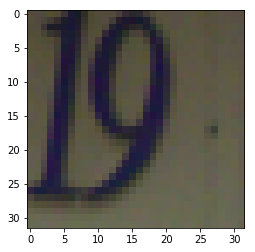

In [9]:
print(X_train.shape)
print(y_train[1])
plt.imshow(X_train[1])
plt.show()

<h2>Torch Dataset</h2>

SVHN dataset is in numpy array , the data could be in Python Array or any other datatype that could converted to torch tensors.      

In [10]:
class SVHNDataset(Dataset):

    def __init__(self,images,labels,transform=None):
        
        """Args:
             
             images (Numpy Array): Text corpus 
             Labels (Numpy Array): Labels corresponding to each image 
             transform (Optional): If any torch transform has to be performed on the dataset
             
        """
        
        "Attributes self.data and self.targets must be initialized"
        
        #<--Data must be initialized as self.data,self.train_data or self.test_data
        self.data=images
        #<--Targets must be initialized as self.targets,self.test_labels or self.train_labels
        self.targets=labels
        
        #<--The data and target must be converted to torch tensors before it is returned by __getitem__ method
        self.to_torchtensor()
        
        #<--If any transforms have to be performed on the dataset
        self.transform = transform
        
        
    def to_torchtensor(self):
        
        "Transform Numpy Arrays to Torch tensors"
        
        self.data=torch.from_numpy(self.data)
        self.labels=torch.from_numpy(self.targets)
    
        
    def __len__(self):
        
        """Required Method
            
           Returns:
        
                Length [int]: Length of Dataset/batches
        
        """
        
        return len(self.data)
    

    def __getitem__(self, idx):
        
        """Required Method
        
           The output of this method must be torch tensors since torch tensors are overloaded 
           with share() method which is used to share data to workers.
        
           Args:
                 
                 idx [integer]: The index of required batch/example
                 
           Returns:
                 
                 Data [Torch Tensor]:     The training examples
                 Target [ Torch Tensor]:  Corresponding labels of training examples 
        
        """
        
        sample=self.data[idx]
        target=self.targets[idx]
                
        if self.transform:
            sample = self.transform(sample)

        return sample,target

Call the federate method with the workers as arguments on the torch dataset instance and provide it as an argument to the federated data loader. This distributes the dataset to the required workers and returns their corresponding pointer tensors. The federated train loader can now be used to load the pointer tensors of corresponding examples and labels iteratively like regular torch data loader. 

In [11]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
                         SVHNDataset(X_train,y_train)
                         .federate((bob, alice)),batch_size=args.batch_size)

<h2>Syft Base Datasets</h2>

Syft Base Dataset is a simplified dataset feature of Syft Library that allows you create datasets by simply providing training data and corresponding labels. This could also be utilized in federated data loaders. Ensure the inputs to BaseDataset are torch tensors. 

In [12]:
base=sy.BaseDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))

In [17]:
base_federated=base.federate((bob, alice))

In [18]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
                         base_federated,batch_size=args.batch_size)

<h1></h1>

## Well Done!

And voilà! We now know how to create a custom dataset that works with federated data loaders. 

## Shortcomings of this Example

Currently Federated datasets were developed to allow users to perform federated learning easily with federated data loaders. If you have any features that could improve your experience feel free to create an Github Issue. 

# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!


### Star PySyft on GitHub

The easiest way to help our community is just by starring the repositories! This helps raise awareness of the cool tools we're building.

- [Star PySyft](https://github.com/OpenMined/PySyft)

### Pick our tutorials on GitHub!

We made really nice tutorials to get a better understanding of what Federated and Privacy-Preserving Learning should look like and how we are building the bricks for this to happen.

- [Checkout the PySyft tutorials](https://github.com/OpenMined/PySyft/tree/master/examples/tutorials)


### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! 

- [Join slack.openmined.org](http://slack.openmined.org)

### Join a Code Project!

The best way to contribute to our community is to become a code contributor! If you want to start "one off" mini-projects, you can go to PySyft GitHub Issues page and search for issues marked `Good First Issue`.

- [Good First Issue Tickets](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)

### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

- [Donate through OpenMined's Open Collective Page](https://opencollective.com/openmined)